In [1]:
import numpy as np
import math
#from scipy import linalg as la
from numpy import linalg as la
import random
import itertools
from ed import*
import time
# here is the noise circuit
from cft_functions import*

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [320]:
def ising_gs(num_qubits):
    H = build_TFIZ(num_qubits,-1,-1,0,pbc=True).todense()
    evl, evcs = la.eigh(H)
    psi_gs = np.array(evcs[:,0])
    U = evcs
    return psi_gs

def reduced_dm(num_qubits,sub_size,basis = 'x',p = 0):
    psi_gs = ising_gs(num_qubits)
    inds = (f'{i}' for i in range(num_qubits))
    psi = qtn.Tensor(psi_gs.reshape([2]*num_qubits), inds)
    inds_reduced = tuple([str(i) for i in range(num_qubits-sub_size,num_qubits)])
    return partial_dm_dephasing(psi, inds_reduced,p = p, basis = basis).data

def pt_moment(rho,sub_size,tp_size = 0,order = 2, ob = np.eye(2)):
    ob_total = np.kron(ob,np.identity(2**(sub_size-1)))
    rho_cp = rho.copy()
    for i in range (tp_size):
        rho_cp = rho_cp.swapaxes(i,i+sub_size)
    rho_reshaped = rho_cp.reshape(2**(sub_size), 2**(sub_size))
    prod = rho_reshaped.copy()@ob_total
    for i in range (order-1):
        prod = prod@rho_reshaped@ob_total
    return prod
    
def pt_moment_normalized(num_qubits,sub_size,tp_size = 0,order = 2,basis = 'x',p = 0, ob= np.eye(2)):
    '''
    ob: whether adding a observable
    basis: direction of channeling
    sub_size: size of the subsystem
    tp_size: transpose the qubits within this size
    '''
    rho = reduced_dm(num_qubits,sub_size, basis = basis,p = p)

    pt_mo = pt_moment(rho,sub_size,tp_size = tp_size,order = order,ob = ob)
    norm = pt_moment(rho,sub_size,tp_size = 0,order = order)

    return np.trace(pt_mo)/np.trace(norm)

## Preparing the state
The final target is to measure 
$${\rm Tr}(\rho X_1 \rho X_1)/{\rm Tr}(\rho^2)$$ 
where rho is a ground state vector channeled by depolarizing noise in a certain direction 

In [78]:
#Implement a vqe circuit

# Nov. 12
#@YZhang
import quimb.tensor as qtn
import quimb as qu
import torch
from vqe_functions import*
import quimb.tensor as qtn
import quimb as qu
import pickle 
from numpy import array

L= num_qubits = 6
depth_initial = 1
depth_final = 3
depth_step = 1

def energy_fn(psi):
    # compute the total energy, here quimb handles constructing 
    # and contracting all the appropriate lightcones 

    for i in range (L):
        psi = psi&psi_pqc.tensors[i]
    psi_H = psi.H
    for i in range(L):
        psi_H  = psi_H.reindex({f'k{i}':f'b{i}'})
    return torch.real((psi_H &H& psi).contract(all,optimize = opti))


class TNModel_energy(torch.nn.Module):

    def __init__(self, tn):
        super().__init__()
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(tn)
        # n.b. you might want to do extra processing here to e.g. store each
        # parameter as a reshaped matrix (from left_inds -> right_inds), for 
        # some optimizers, and for some torch parametrizations
        self.torch_params = torch.nn.ParameterDict({
            # torch requires strings as keys
            str(i): torch.nn.Parameter(initial)
            for i, initial in params.items()
        })

    def forward(self):
        # convert back to original int key format
        params = {int(i): p for i, p in list(self.torch_params.items())}
        # reconstruct the TN with the new parameters
        psi = qtn.unpack(params, self.skeleton)
        # isometrize and then return the energy
        return energy_fn(norm_fn(psi))
        
for depth in range(depth_initial,depth_final,depth_step):
    if depth == depth_initial:
        rd = True
    else:
        rd = False 
    psi_pqc = qmps_f(L, in_depth= depth, n_Qbit=num_qubits-1, qmps_structure="pollmann", canon="left",val_iden = 0.000,rand = rd)
    psi = psi_pqc.tensors[L]
    for i in range (L+1,len(psi_pqc.tensors)):
        psi = psi&psi_pqc.tensors[i]
        
    psi_pqc.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.complex128))
    psi.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.complex128))
    
    if depth!= depth_initial:
        psi_c = psi.copy()
        psi_nm = load_para(psi_c, dictionary)
    
    Ham = np.array(build_TFIZ(num_qubits,-1,-1,0,pbc=True).todense())
    inds = [f'k{i}' for i in range(num_qubits)]+[f'b{i}' for i in range(num_qubits)]
    H = qtn.Tensor(Ham.reshape([2]*2*num_qubits),tuple(inds))
    H.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.complex128))
    
    #E = Variable(torch.tensor(-30, dtype=torch.complex128), requires_grad=True)
    if depth== depth_initial:
        psi_nm = psi
        model = TNModel_energy(psi_nm)
    else:
        model= TNModel_energy(psi_nm)
    
    import warnings
    from torch import optim
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            message='.*trace might not generalize.*',
        )
        model = torch.jit.trace_module(model, {"forward": []})
        
    import torch_optimizer
    import tqdm
    
    lrs = [0.001,0.0001]
    for lr in lrs:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=250, gamma=0.5)
        its = 2000
        pbar = tqdm.tqdm(range(its),disable=False)
        
        for _ in pbar:
            show_progress_bar=False
            optimizer.zero_grad()
            loss = model()
            loss.backward()
            def closure():
                return loss
            optimizer.step()
            pbar.set_description(f"{loss}")
            progress_bar_refresh_rate=0
    k = 0
    dictionary = save_para(psi_nm)
    with open(f'mps_parameters/ising_critical_vqe_ladder_L{L}_depth{depth}.pkl', 'wb') as f:
        pickle.dump(dictionary, f)

-7.726943080031223: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 156.66it/s]


In [4]:
# check energy overlap
H = build_TFIZ(num_qubits,-1,-1,0,pbc=True).todense()
evl, evcs = la.eigh(H)
evl[0]
print('relative energy difference: ', (loss.float().detach().numpy()- evl[0])/evl[0])

relative energy difference:  -5.999351188298e-05


## Qiskit emulation functions of the experiment

In [309]:
# synthesis circuit
import qiskit
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister,Aer
from qiskit.quantum_info.operators import Operator
from qiskit.providers.aer import AerSimulator
# Select the AerSimulator from the Aer provider

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from scipy.stats import unitary_group
from qiskit.extensions import UnitaryGate
tensor_list = (norm_fn(psi_nm)).tensors[:]
nb = num_qubits-1

def cft_circ(num_qubits, tensor_list, observables,qmps_structure="pollmann", p_device = 0, p_channel = 0, channel_basis ='X'):
    # the ladder version
    q= QuantumRegister(num_qubits)
    c= ClassicalRegister(num_qubits)
    circ= QuantumCircuit(q, c)
    cnt = 0
    
    #for l in range(L):
    for d in range (depth):
        if qmps_structure=="pollmann":
            for i in range(0,num_qubits-1,1):
                U = UnitaryGate(tensor_list[cnt].data.reshape(4,4).T, label = 'U')
                #Decomposed =  qiskit.quantum_info.synthesis.TwoQubitWeylDecomposition(U, fidelity=0.999999999, )
                #a = Decomposed.circuit()
                circ.append(U, [q[i+1],q[i]])
                #circ = circ.compose(Decomposed.circuit(), [q[(i+1+l)%(nb+1)],q[(i+l)%(nb+1)]])
                cnt += 1
        else:
            if d%2 == 0:
                for i in range(0,num_qubits-1,2):
                    U = UnitaryGate(tensor_list[cnt].data.reshape(4,4).T, label = 'U')
                    #Decomposed =  qiskit.quantum_info.synthesis.TwoQubitWeylDecomposition(U, fidelity=0.999999999, )
                    #a = Decomposed.circuit()
                    circ.append(U, [q[i+1],q[i]])
                    #circ = circ.compose(Decomposed.circuit(), [q[(i+1+l)%(nb+1)],q[(i+l)%(nb+1)]])
                    cnt += 1
            else: 
                for i in range(1,num_qubits-1,2):
                    U = UnitaryGate(tensor_list[cnt].data.reshape(4,4).T,label = 'U')
                    circ.append(U, [q[i+1],q[i]])
                    cnt += 1

    simulator = Aer.get_backend('statevector_simulator')
    for l in range(num_qubits):
        circ.id(q[l])
        
        if observables[l] == 0:
            circ.h(q[l])
            
        elif observables[l] == 1:
            circ.sdg(q[l])
            circ.h(q[l])#rotating into y-basis
            # Create a Quantum Program for execution
        circ.measure(q[l],c[l])
    result = simulator.run(circ,shots= 1,noise_model=get_noise(p_device, p_channel,n_qubit= 2,channel_basis = channel_basis)).result()
    #result = simulator.run(circ,shots= 1,noise_model=None).result()

    counts = result.get_counts(circ)
    strings = np.array([int(i) for i in list(counts.keys())[0]][::-1])*(-2)+1
    return strings
    #return circ,q,c
    
def circ_meas(circ, q, c, observables, qum_qubits, p_device = 0, p_channel = 0, channel_basis ='X'):
    #simulator = Aer.get_backend('aer_simulator')
    simulator = Aer.get_backend('aer_simulator')
    for l in range(num_qubits):
        if observables[l] == 0:
            circ.h(q[l])
        elif observables[l] == 1:
            circ.sdg(q[l])
            circ.h(q[l])#rotating into y-basis
            # Create a Quantum Program for execution
        circ.id(q[l])
        circ.measure(q[l],c[l])
    result = simulator.run(circ,shots= 1,noise_model=get_noise(p_device, p_channel,n_qubit= 2,channel_basis = channel_basis)).result()
    #result = simulator.run(circ,shots= 1,noise_model=None).result()

    counts = result.get_counts(circ)
    strings = np.array([int(i) for i in list(counts.keys())[0]][::-1])*(-2)+1
    return strings

## Simulation shots and data processing

This example shows the calculation of Tr($\rho X_1 \rho X_1$)

In [315]:
def calculate_classical_shadow(circuit_template, tensor_list, shadow_size, num_qubits, p_device = 0, p_channel = 0, channel_basis ='X'):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (-1, 1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """
    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli

    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))

    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        obs = [int(unitary_ids[ns, i]) for i in range(num_qubits)]
        #circ, q, c, = circuit_template(num_qubits,tensor_list)
        outcomes[ns, :] =  circuit_template(num_qubits, tensor_list, obs,qmps_structure="pollmann", p_device = p_device, p_channel = p_channel, channel_basis =channel_basis)#circ_meas(circ, q, c, obs, num_qubits, p_device = p_device, p_channel = p_channel, channel_basis =channel_basis)
    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)
# getting a better estimation with 

def PT_moment(shadow, A_qubits, B_qubits, order = 2,obs = None):
    '''
    given:
    shadow_list: a list of single qubit classical shadows
    Renyi_index: an integer
    A_qubits: a list of qubits that region A is consist of 
    B_qubits: a list of qubits that region B is consist of 
    calculate the PT moment
    '''
    estimate = 0
    qubit_list = A_qubits + B_qubits
    Nu = len(shadow[0])
    rho_1, rho_2, rho_3 = shadow_state_reconstruction(shadow, qubit_list, transposed = A_qubits,obs = obs)
    if obs!= None:
        Nu = len(shadow[0])* len(obs)
    if order ==3:
        PT = (np.einsum('ab,bc,ca', rho_1, rho_1,rho_1) - 3*np.einsum('ab,ba', rho_1,rho_2, ) + 2*np.einsum('aa', rho_3))/(Nu*(Nu-1)*(Nu-2))
    else: 
        PT = (np.einsum('ab,ba', rho_1, rho_1) - np.einsum('aa', rho_2, ))/(Nu*(Nu-1))
    return PT


PT_shadow = []
qubit_list = list(np.arange(num_qubits))
b = 'X'
p_channel = 0.05 #channeling strength
p_device = 0 #device noise strength
num_snapshots = 20000 # number of repeats in the circuit
obs = [np.kron(np.identity(2**(i)), np.kron(np.array([[ 0.,  1.,],[ 1,  0]]),np.identity(2**(num_qubits-i-1)))) for i in range(num_qubits)] # the observables; we make use of the translational invariance in post-processing and thus create a list

def XX_estimation(tensor_list, num_snapshots, num_qubits, obs = obs, p_device = p_device, p_channel = p_channel, channel_basis =b):
    PT_average = np.zeros(num_qubits)
    shadow = calculate_classical_shadow(cft_circ, tensor_list, num_snapshots, num_qubits, p_device = p_device, p_channel = p_channel, channel_basis =b)
    print('completed shadow simulation, '+ f' lapse of time: {time.time()-t0}s')

    i = 0
    A_qubits = qubit_list[:i] #qubits that we transpose; none in this case
    B_qubits = qubit_list[i:]
    XX = PT_moment(shadow, A_qubits,B_qubits,order = 2,obs = obs)
    norm = PT_moment(shadow, A_qubits,B_qubits,order = 2,obs = None)
    print(f'completed PT calculation, lapse of time: {time.time()-t0}s')
    return XX/norm



## Comparing to ED calculation

In [316]:
t0= time.time()
b = 'X'
p_list = [0.05*i for i in range (1,5)]
XX_shadow = [XX_estimation(tensor_list, num_snapshots, num_qubits, obs = obs,p_device = p_device, p_channel =p_channel, channel_basis =b) for p_channel in p_list]

completed shadow simulation,  lapse of time: 76.36582899093628s
completed PT calculation, lapse of time: 226.60324811935425s
completed shadow simulation,  lapse of time: 301.71218395233154s
completed PT calculation, lapse of time: 443.3884630203247s
completed shadow simulation,  lapse of time: 517.2374269962311s
completed PT calculation, lapse of time: 660.9037640094757s
completed shadow simulation,  lapse of time: 734.0984580516815s
completed PT calculation, lapse of time: 885.7114200592041s


In [325]:
b.lower()

'x'

In [321]:
sub_size = num_qubits
XX_ED = [pt_moment_normalized(num_qubits,sub_size,tp_size = 0,order = 2,basis = 'x',p = p_channel, ob= np.array([[ 0.,  1.,],[ 1,  0]])) for p_channel in p_list]
#plt.scatter(np.log(np.sin(np.pi*np.arange(4)/6)),-1/2*np.log(np.array(Est_z)/Est_z[0]),marker = '^',s = 88)

Text(0.5, 1.0, 'tr($\\rho X \\rho X$)/tr($\\rho \\rho$), L = 6,20000 shots')

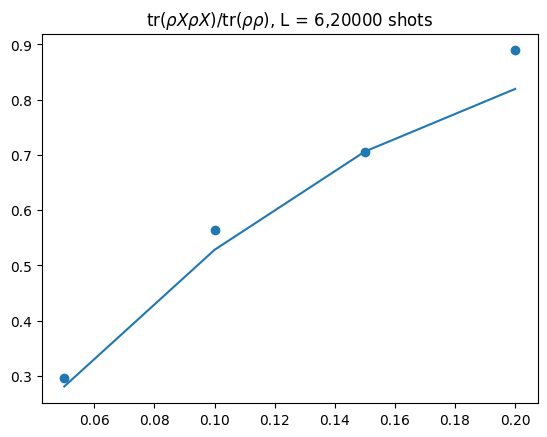

In [324]:
plt.scatter(p_list,XX_shadow)
plt.plot(p_list,XX_ED)
plt.title(rf'tr($\rho X \rho X$)/tr($\rho \rho$), L = {num_qubits},{num_snapshots} shots')